In [20]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import warnings
import gcsfs
from xhistogram.xarray import histogram
import intake
import util
import gsw
import dask
nm = 12

In [21]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

pangeo-cmip6-ESM Collection with 28657 entries:
	> 10 activity_id(s)

	> 23 institution_id(s)

	> 48 source_id(s)

	> 29 experiment_id(s)

	> 86 member_id(s)

	> 23 table_id(s)

	> 190 variable_id(s)

	> 7 grid_label(s)

	> 28657 zstore(s)

	> 59 dcpp_init_year(s)

In [22]:
cat = col.search(experiment_id=['historical'], institution_id='NCAR', table_id='Omon', member_id='r1i1p1f1', variable_id=['thetao','so','siconc'], grid_label='gn')
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
14574,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,so,gn,gs://cmip6/CMIP/NCAR/CESM2/historical/r1i1p1f1...,NaN
14580,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,thetao,gn,gs://cmip6/CMIP/NCAR/CESM2/historical/r1i1p1f1...,NaN


In [23]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': False})
dset_dict.keys()

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


dict_keys(['CMIP.NCAR.CESM2.historical.Omon.gn'])

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


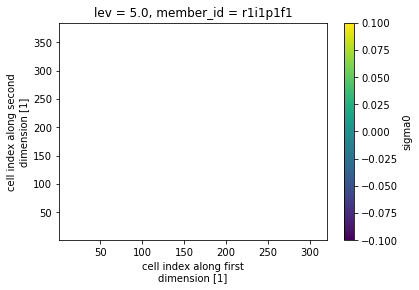

In [27]:
def calc_mld(ds):
    # getting time slice and selecting Augusts
    ds = ds.isel(time=slice((1986-1850)*nm,(2006-1850)*nm))
    ds = ds.isel(time=np.arange(7,20*nm,nm)).mean(dim='time')
    
    # Make depth/lev coordinate uniform in name
    if 'depth' in ds:
        ds.depth = xr.Dataset.rename({'depth':'lev'})
    
    # and units
    if ds.lev.units == 'centimeters':
        ds.lev.values = ds.lev.values/100
    
    # calculate potential density using gibbs sea water package
    cthetao = xr.apply_ufunc(gsw.CT_from_pt, ds.so, ds.thetao, dask='parallelized',
                                             output_dtypes=[float,]).rename('cthetao').to_dataset() 
    ds = xr.merge([cthetao, ds])
    
    # using sigma0 here to calculate mixed layer depth
    sigma0=xr.apply_ufunc(gsw.density.sigma0,ds.so, ds.cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('sigma0').to_dataset()
    ds = xr.merge([sigma0, ds])
  
    # Interpolate potential density
    dsi = ds.sigma0.interp(lev=np.linspace(0,20,21))
    surf_dens = dsi.sel(lev = 10)
    
    ds.sigma0.isel(lev=0).plot()
    
    # calculate sigma2
    sigma2=xr.apply_ufunc(gsw.density.sigma2,ds.so, ds.cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('sigma2').to_dataset()
    ds = xr.merge([sigma2, ds])
    
    # Calculate mixed layer depth based on density difference from 10m
    dens_diff = ds.sigma0 - surf_dens
    dens_diff = dens_diff.where(dens_diff > 0.03)
    mld = dens_diff.lev.where(dens_diff==dens_diff.min(['lev'])).max(['lev'])
    
    #dens_diff.isel(lev=0).plot()

    return ds


for i in dset_dict:
     newds = calc_mld(dset_dict[i])   

In [ ]:
    # add mld to dataset
    ds['mld'] = mld
    
    # find depth of bottom
    test = ds.sigma0 + ds.lev
    print(test)
    bottom_depth = ds.lev.where(test == test.max(dim='lev')).max(dim='lev')
    bottom_depth.plot()
    #add to dataset
    ds['bottom_depth'] = bottom_depth
    ds['relative_depth'] = mld/bottom_depth
        
    # find bottom potential density referenced to 2000m and temperature
    bottom_sigma2 = ds.sigma2.where(test == test.max(['lev'])).max(dim='lev')
    print(bottom_sigma2)
    ds['bottom_sigma2'] = bottom_sigma2
    
    bottom_temp = ds.thetao.where(test == test.max(['lev'])).max(dim='lev')
    ds['bottom_temp'] = bottom_temp
    
    print(ds)
    return ds

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


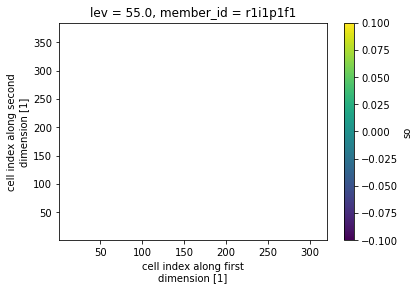

In [29]:
# for i in dset_dict:
#      newds = calc_mld(dset_dict[i]) 
        
newds.so.isel(lev=5).plot()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


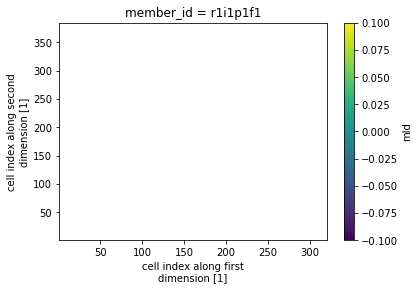

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


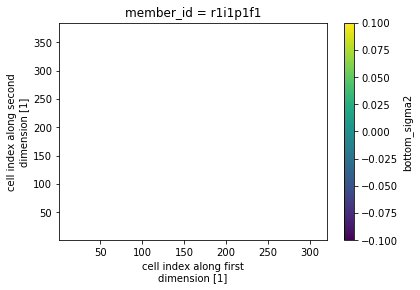

In [8]:
for i in dset_dict:
    dens_diff = dset_dict[i].sigma0 - surf_dens
#     print(dens_diff.isel(time=0).min().values)
    dens_diff = dens_diff.where(dens_diff > 0.03)
#     print(dens_diff.shape)
    mld = dens_diff.lev.where(dens_diff==dens_diff.min(['lev'])).max(['lev'])

AttributeError: 'Dataset' object has no attribute 'sigma0'

In [ ]:
# Mixed layer depth threshold 